# Introduction
This notebook performs data analysis and clustering on the results of the survey conducted about electricity consumption. The steps include data cleaning, preprocessing, clustering using KMeans and Hierarchical Clustering, PCA, and evaluation of the results.

## Importing Required Libraries

In [219]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
import logging, sys
import seaborn as sns
import matplotlib.cm as cm
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from scipy import stats
from pca import pca
import colorsys

## Loading and Merging the Datasets 

In [220]:
# Read the CSV files
survey_ita = pd.read_csv("Survey Ita.csv", delimiter=',')
survey_en = pd.read_csv("Survey Eng.csv", delimiter=',')

# Aligning Italian columns to English based on position
column_mapping = dict(zip(survey_ita.columns, survey_en.columns))
survey_ita_renamed = survey_ita.rename(columns=column_mapping)

# Merging the datasets
data = pd.concat([survey_ita_renamed, survey_en], axis=0, ignore_index=True)

# Drop the first column
data = data.iloc[:, 1:]

data = pd.concat([data[4:], data[:4]], ignore_index=True) # Reorder the columns

# Print the combined dataset
data.head()

,What is your age?,What is your current living situation?,What type of residence do you live in?,Do you manage the electricity in your household?,How many people live in your household?,How would you describe your household's energy consumption?,How many times have you changed your electricity provider?,How much do you pay for the electricity monthly?,"Rank the following attributes from most important (1) to least important (7).\nYou can only assign each rank once, so please ensure each attribute has a unique rank. [Reputation and reliability of the provider]","Rank the following attributes from most important (1) to least important (7).\nYou can only assign each rank once, so please ensure each attribute has a unique rank. [Customer service]","Rank the following attributes from most important (1) to least important (7).\nYou can only assign each rank once, so please ensure each attribute has a unique rank. [Ease of understanding the bill]","Rank the following attributes from most important (1) to least important (7).\nYou can only assign each rank once, so please ensure each attribute has a unique rank. [Flexible pricing options (time slots)]","Rank the following attributes from most important (1) to least important (7).\nYou can only assign each rank once, so please ensure each attribute has a unique rank. [Availability of renewable energy options]","Rank the following attributes from most important (1) to least important (7).\nYou can only assign each rank once, so please ensure each attribute has a unique rank. [Accessibility of online tools/mobile app]","Rank the following attributes from most important (1) to least important (7).\nYou can only assign each rank once, so please ensure each attribute has a unique rank. [Bundles (e.g., electricity + gas + internet)]"
0,18-25,Affitto,Appartamento,Si,2,Basso (es. uso minimo di riscaldamento/aria co...,Mai,40-60€,1,5,3,4,6,2,7
1,51+,Proprietà,Casa,Si,4,Alto (es. uso frequente di riscaldamento/aria ...,Due o più volte,100-120€,2,5,4,1,7,6,3
2,26-35,Proprietà,Appartamento,No,4,Alto (es. uso frequente di riscaldamento/aria ...,Mai,Più di 120€,7,6,4,1,2,3,5
3,26-35,Proprietà,Appartamento,Si,2,Basso (es. uso minimo di riscaldamento/aria co...,Mai,Meno di 40€,7,5,3,2,6,4,1
4,36-50,Affitto,Appartamento,Si,2,Moderato (es. uso occasionale del riscaldament...,Mai,Meno di 40€,2,7,5,1,3,4,6


# Cleaning and Preprocessing the Data

- **Trimming Column Names:** Removing leading and trailing spaces from column names.  
- **Renaming Columns:** Updating column names for better readability.  
- **Standardizing Living Situation:** Replacing specific responses with `"Affitto"`.  
- **Converting Household Size Values:** Changing `"nessuna"` to `1` for consistency.  
- **Previewing Data:** Displaying the first few rows of the cleaned dataset. 


In [221]:
# Filter and Clean Data
# Remove leading and trailing whitespaces from column names
data.columns = data.columns.str.strip()

# Change the column names
data.rename(columns={
    data.columns[8]: "Reputation", 
    data.columns[9]: "Customer Service", 
    data.columns[10]: "Bill Readability", 
    data.columns[11]: "Flexible Pricing Option", 
    data.columns[12]: "Availability of Renewable Energy", 
    data.columns[13]: "Accessibility of Online Tools", 
    data.columns[14]: "Bundles (electricity+gas)"
}, inplace=True)


# Replace specific living situation entries with 'Affitto'
living_situation_replacements = {
    "Ho vissuto per il 60% di questo anno in una residenza universitaria e per il restante a casa con i genitori": 'Affitto',
    'Uso gratuito': 'Affitto'
}

# Apply replacements to the 'What is your current living situation?' column
data['What is your current living situation?'] = data['What is your current living situation?'].replace(living_situation_replacements)

# Replace 'nessuna' with 1 in the 'How many people live in your household?' column
data['How many people live in your household?'] = data['How many people live in your household?'].replace({'nessuna': 1})

# Display the cleaned data
data.head()

,What is your age?,What is your current living situation?,What type of residence do you live in?,Do you manage the electricity in your household?,How many people live in your household?,How would you describe your household's energy consumption?,How many times have you changed your electricity provider?,How much do you pay for the electricity monthly?,Reputation,Customer Service,Bill Readability,Flexible Pricing Option,Availability of Renewable Energy,Accessibility of Online Tools,Bundles (electricity+gas)
0,18-25,Affitto,Appartamento,Si,2,Basso (es. uso minimo di riscaldamento/aria co...,Mai,40-60€,1,5,3,4,6,2,7
1,51+,Proprietà,Casa,Si,4,Alto (es. uso frequente di riscaldamento/aria ...,Due o più volte,100-120€,2,5,4,1,7,6,3
2,26-35,Proprietà,Appartamento,No,4,Alto (es. uso frequente di riscaldamento/aria ...,Mai,Più di 120€,7,6,4,1,2,3,5
3,26-35,Proprietà,Appartamento,Si,2,Basso (es. uso minimo di riscaldamento/aria co...,Mai,Meno di 40€,7,5,3,2,6,4,1
4,36-50,Affitto,Appartamento,Si,2,Moderato (es. uso occasionale del riscaldament...,Mai,Meno di 40€,2,7,5,1,3,4,6


In [222]:
# Select relevant columns for clustering
data_attributes = data.iloc[:, 8:]
data_attributes.head(5)

,Reputation,Customer Service,Bill Readability,Flexible Pricing Option,Availability of Renewable Energy,Accessibility of Online Tools,Bundles (electricity+gas)
0,1,5,3,4,6,2,7
1,2,5,4,1,7,6,3
2,7,6,4,1,2,3,5
3,7,5,3,2,6,4,1
4,2,7,5,1,3,4,6


In [223]:
data_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   Reputation                        44 non-null     int64
 1   Customer Service                  44 non-null     int64
 2   Bill Readability                  44 non-null     int64
 3   Flexible Pricing Option           44 non-null     int64
 4   Availability of Renewable Energy  44 non-null     int64
 5   Accessibility of Online Tools     44 non-null     int64
 6   Bundles (electricity+gas)         44 non-null     int64
dtypes: int64(7)
memory usage: 2.5 KB


## Data Visualization   
 
- **Plotting Histograms:** Displaying feature distributions.  
- **Correlation Matrix:** Calculating feature correlations and displaying the heatmap.    
- **Visualizing Data Distribution:** Creating a horizontal boxplot to observe data spread and outliers.  


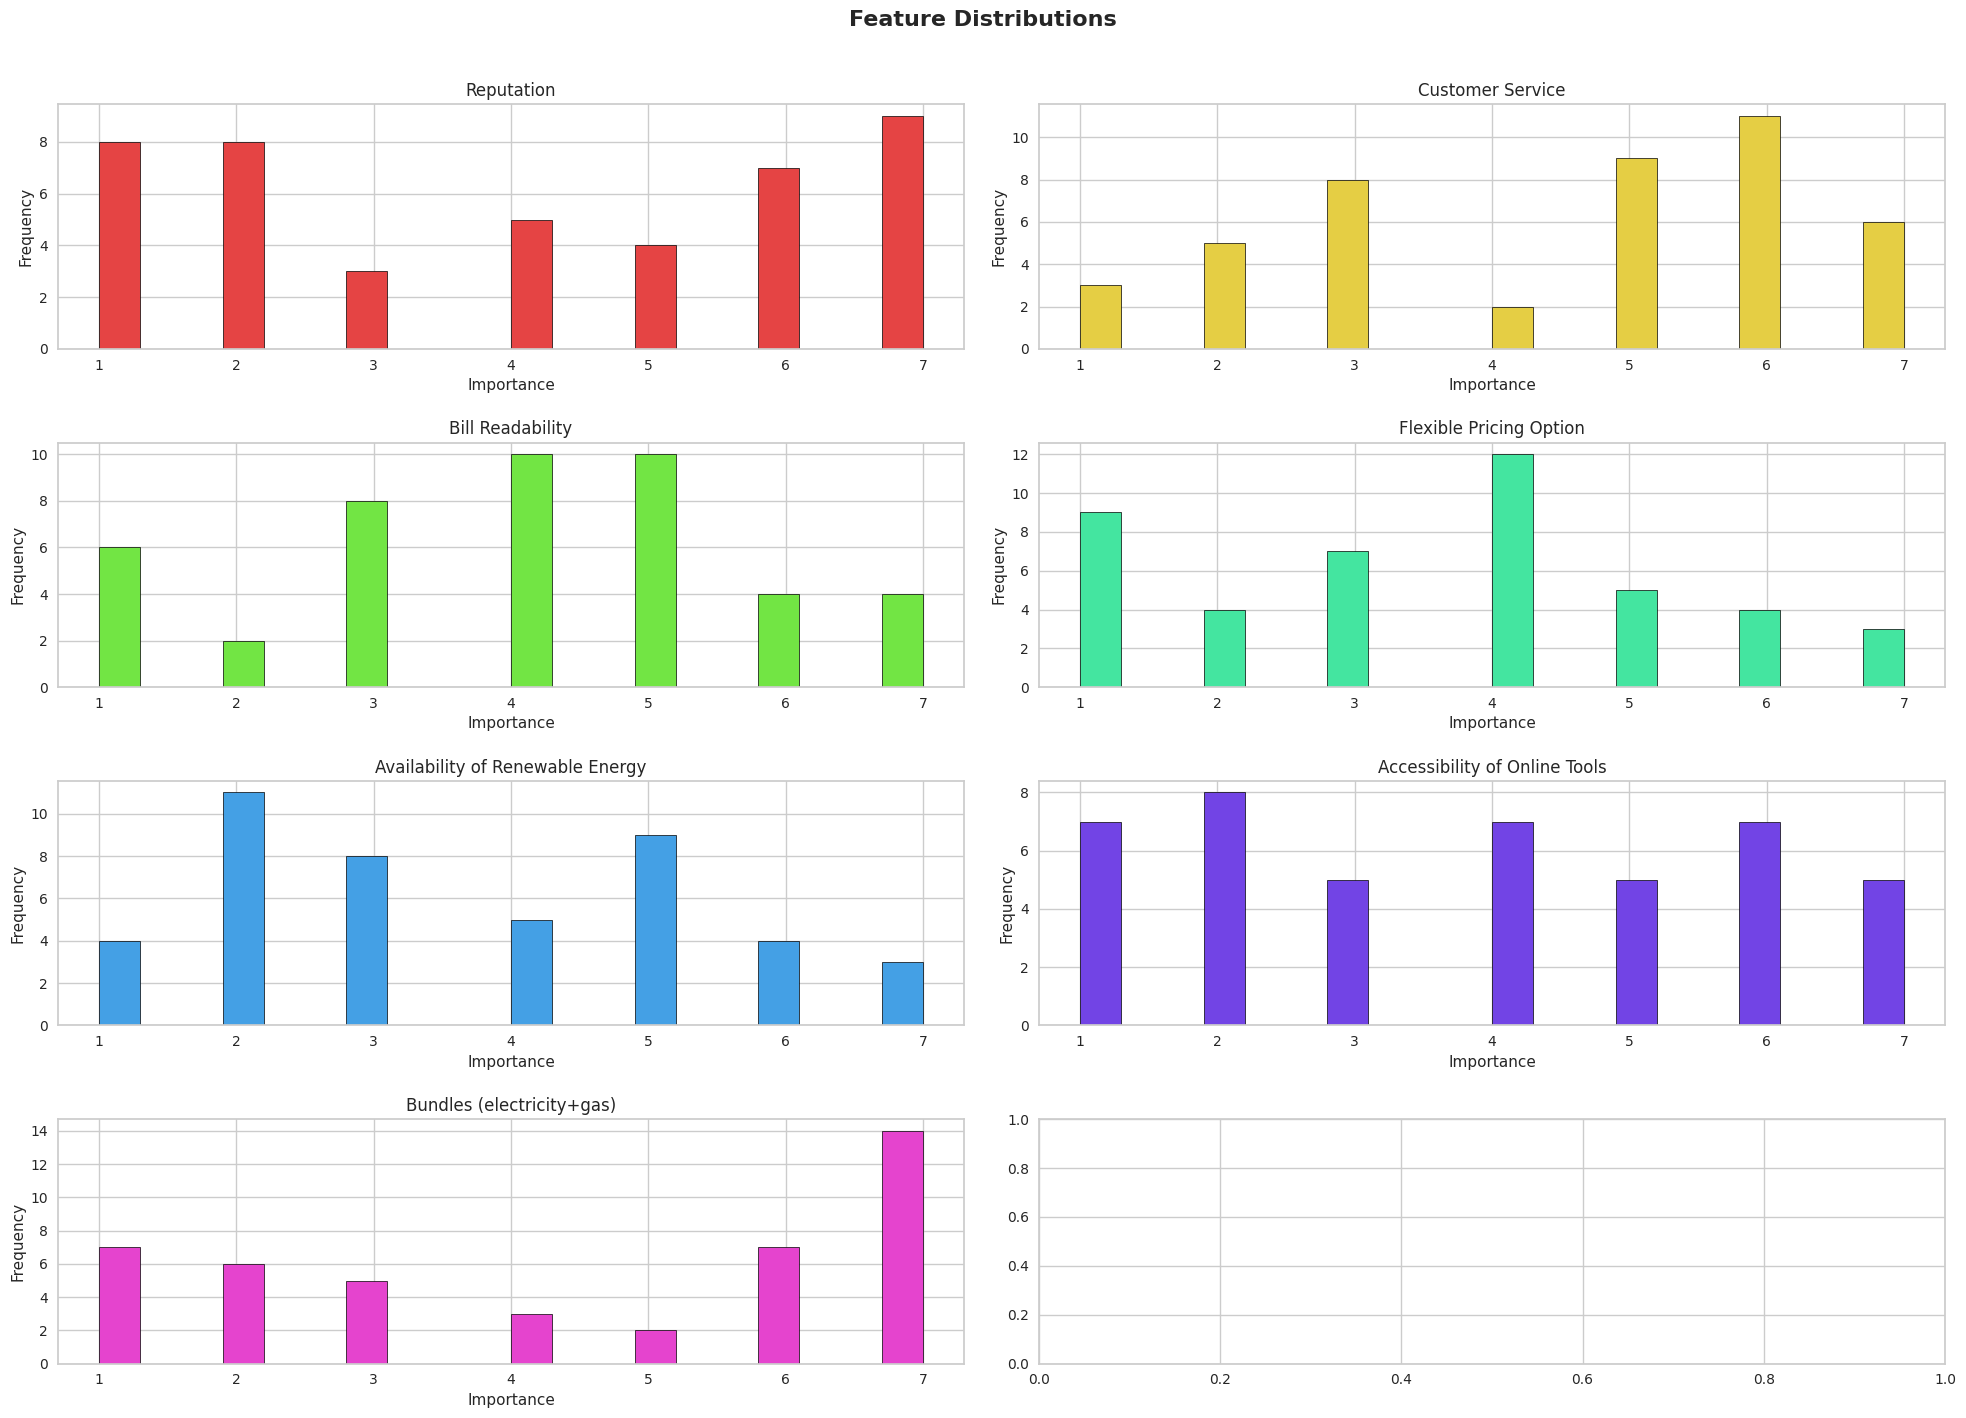

In [224]:
# Generate Colors 
def generate_colors(n):
    colors = []
    for i in range(n):
        hue = i / n  # Distribute colors evenly in the HSV spectrum
        rgb = colorsys.hsv_to_rgb(hue, 0.7, 0.9)  # Convert to RGB
        hex_color = f'#{int(rgb[0]*255):02x}{int(rgb[1]*255):02x}{int(rgb[2]*255):02x}'  # Convert to hex
        colors.append(hex_color)
    return colors

num_features = data_attributes.shape[1]  # Number of features
hist_colors = generate_colors(num_features)  # Generate colors for each histogram

# Plot Histograms with Custom Colors
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
axes = axes.flatten()
for idx, (ax, col) in enumerate(zip(axes, data_attributes.columns)):
    data_attributes[col].hist(bins=20, ax=ax, color=hist_colors[idx], edgecolor='black', linewidth=0.5)
    ax.set_title(col)
    ax.set_xlabel("Importance")  
    ax.set_ylabel("Frequency")  
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Feature Distributions", fontsize=16, fontweight="bold")

plt.show()

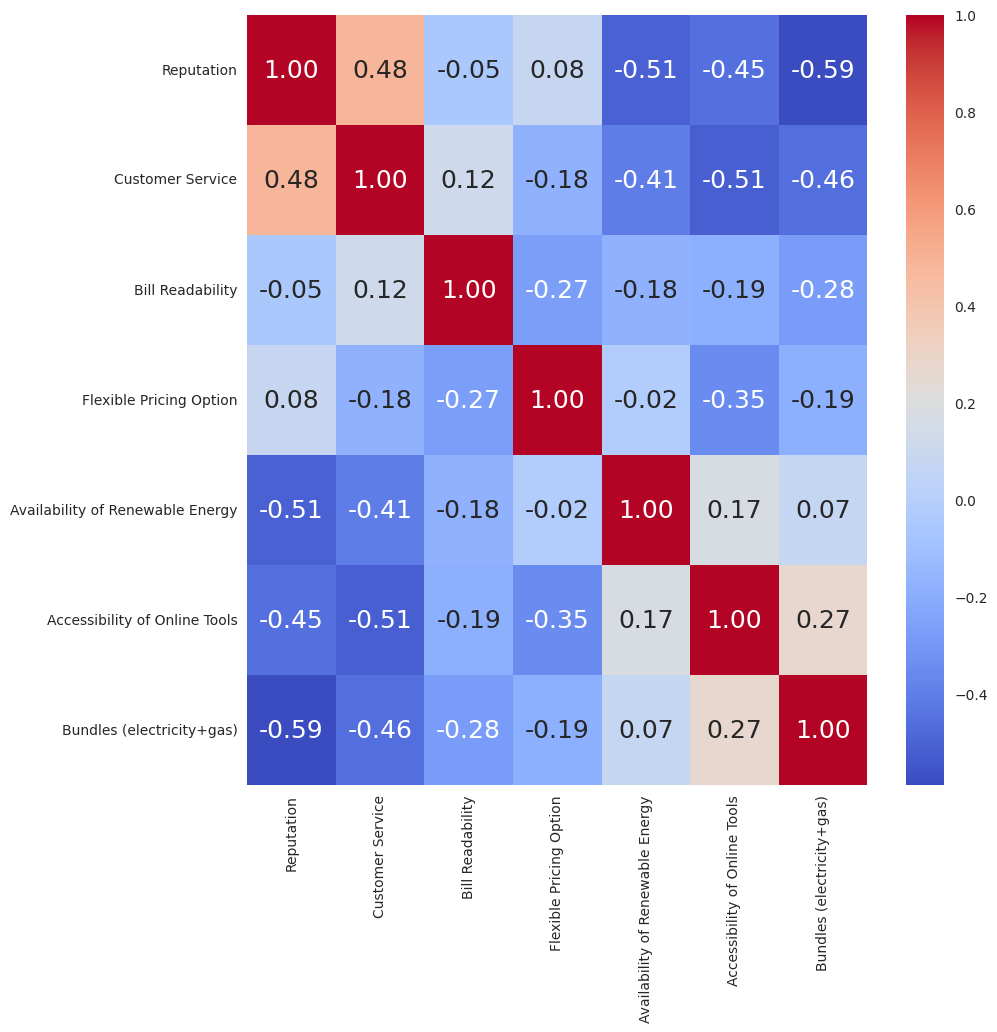

In [225]:
# Correlation Matrix
correlation_matrix = data_attributes.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

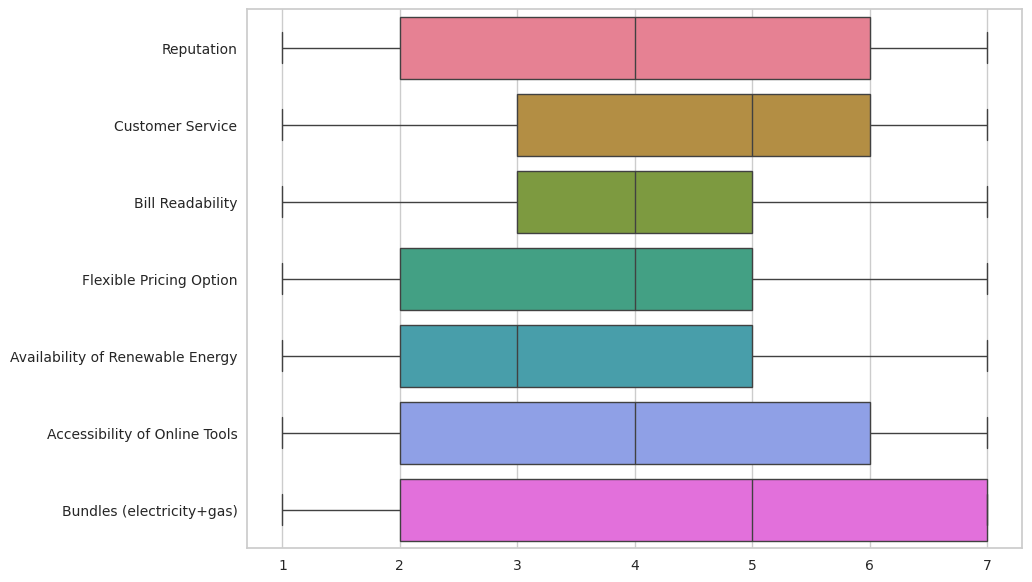

In [226]:
# Visualize the distribution of the data
plt.figure(figsize=(10, 7))
sns.boxplot(data=data_attributes, orient='h')
plt.show()

# Clustering Analysis   


## Elbow Method and Silhouette Score

- **Plotting Elbow Method:** Using K-Means inertia to determine the optimal number of clusters.  
- **Using Yellowbrick Elbow Method:** Visualizing the elbow point with Yellowbrick.  
- **Plotting Silhouette Scores:** Analyzing the quality of clustering by visualizing silhouette scores for different cluster counts. 

In [227]:
data_clust=data_attributes.copy()

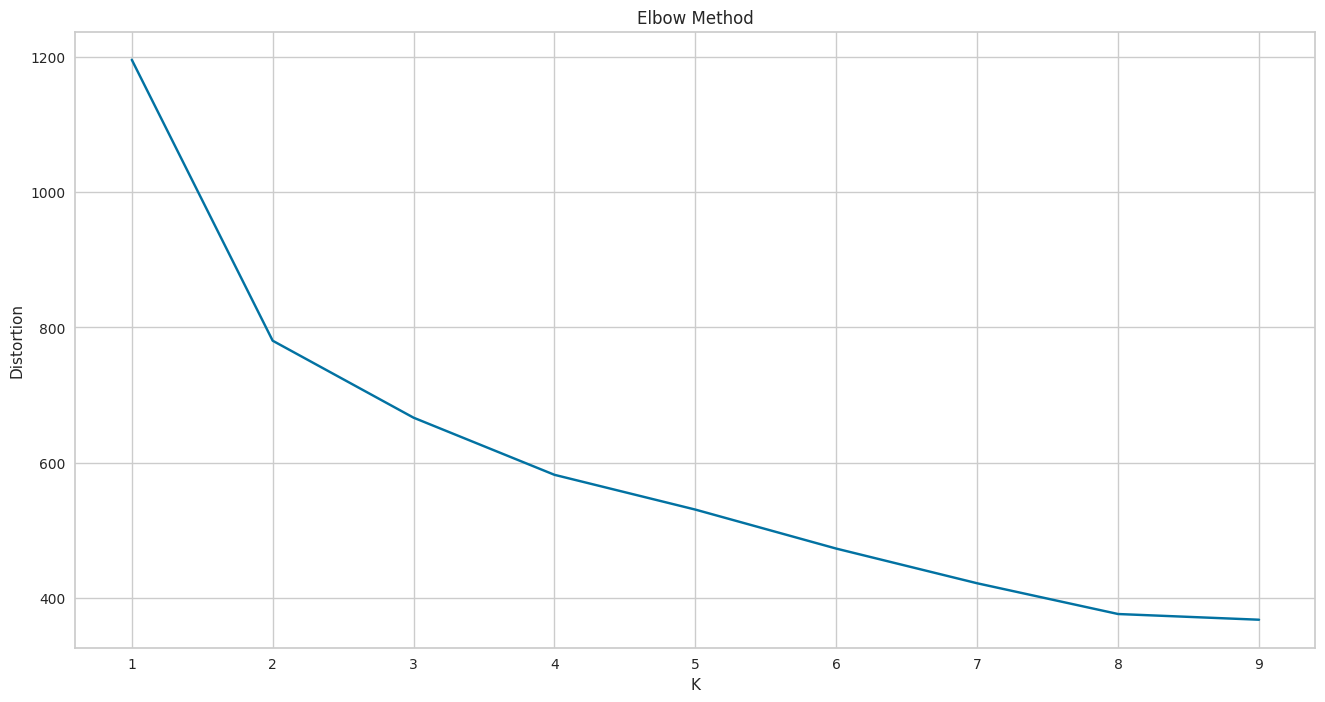

In [228]:
warnings.filterwarnings("ignore")
def plot_kmeans_elbow(data, max_clusters=10):
    distortions = []
    for K in range(1, max_clusters):
        kmeans = KMeans(n_clusters=K, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(16, 8))
    plt.plot(range(1, max_clusters), distortions, 'bx-')
    plt.xlabel('K')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

plot_kmeans_elbow(data_clust)

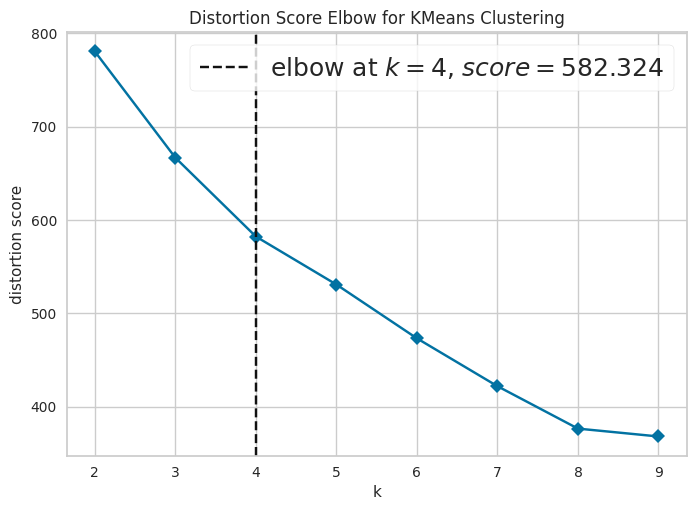

In [229]:
def plot_yellowbrick_elbow(data, k_range=(2, 10)):
    model = KMeans(random_state=42)
    visualizer = KElbowVisualizer(model, k=k_range, timings=False)
    visualizer.fit(data)
    visualizer.show()

plot_yellowbrick_elbow(data_clust)

For n_clusters = 2, The average silhouette_score is : 0.2964187830181131
For n_clusters = 3, The average silhouette_score is : 0.22829940398795132
For n_clusters = 4, The average silhouette_score is : 0.145753259525624
For n_clusters = 5, The average silhouette_score is : 0.18225241672921247


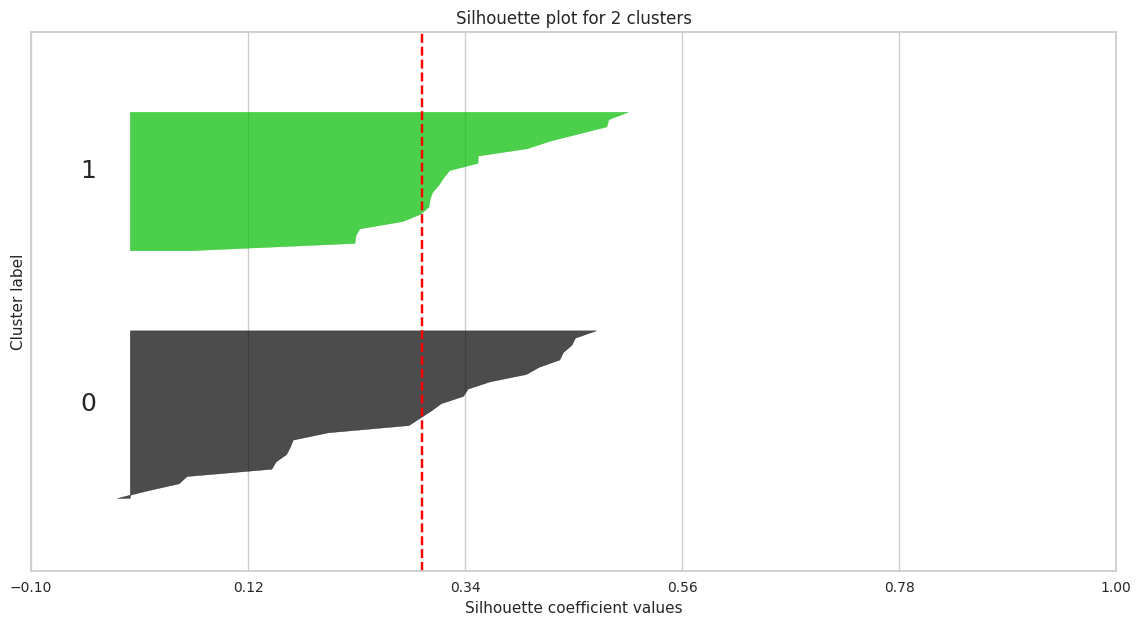

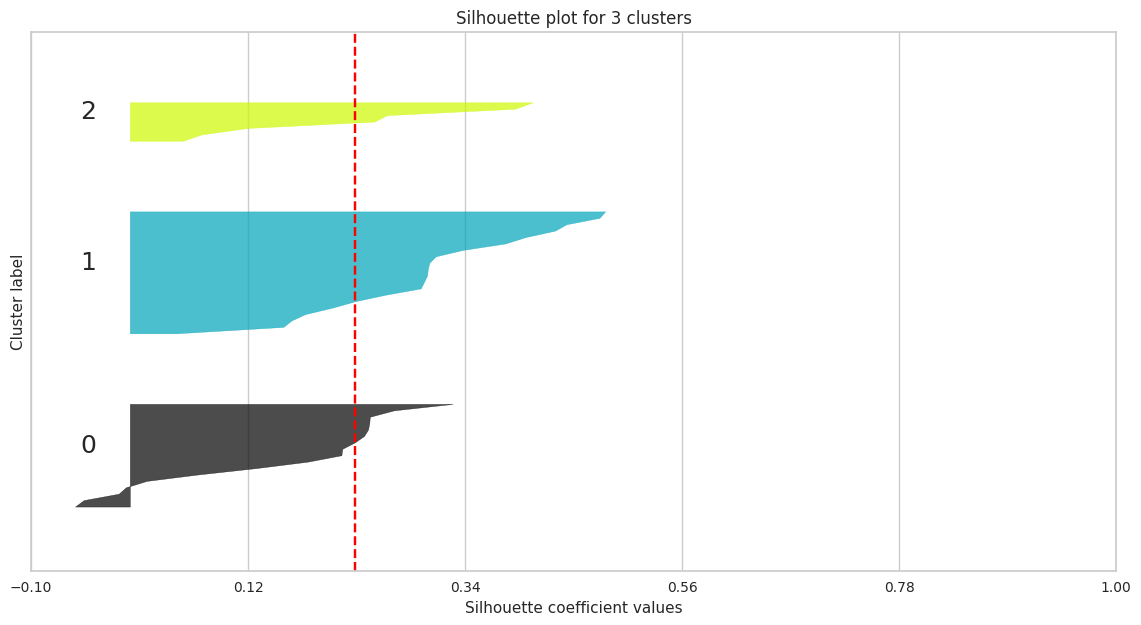

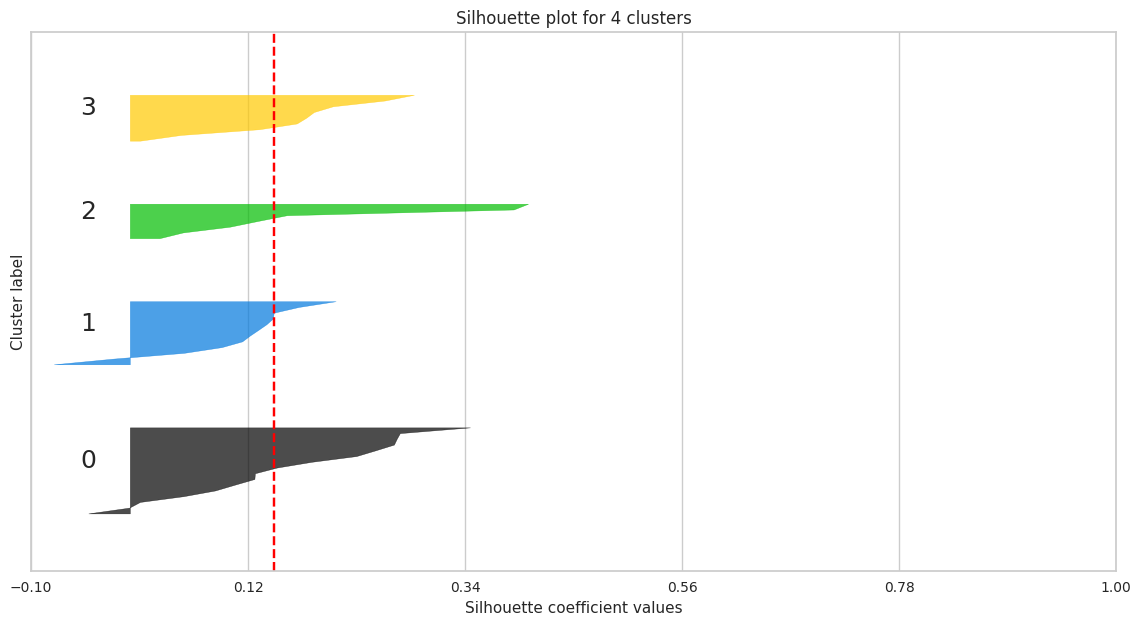

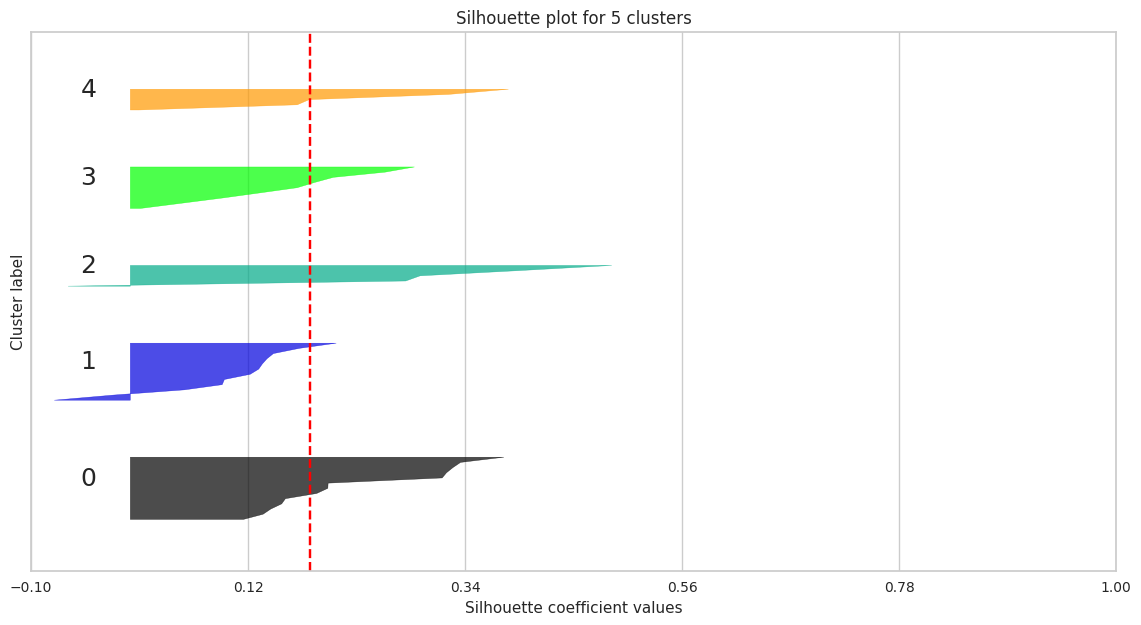

In [230]:
def plot_silhouette(data, range_n_clusters, random_state=10):
    # Convert to numpy array if the input is a DataFrame
    X = data.to_numpy() if hasattr(data, "to_numpy") else np.array(data)

    for n_clusters in range_n_clusters:
        fig, ax = plt.subplots(figsize=(14, 7))

        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Clustering
        clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = clusterer.fit_predict(X)

        # Compute silhouette score
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(f"For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Get silhouette values for the current cluster
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = len(ith_cluster_silhouette_values)
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                             facecolor=color, edgecolor=color, alpha=0.7)

            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # Space for next cluster

        ax.set_title(f"Silhouette plot for {n_clusters} clusters")
        ax.set_xlabel("Silhouette coefficient values")
        ax.set_ylabel("Cluster label")
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_yticks([])
        ax.set_xticks(np.linspace(-0.1, 1, 6))

    plt.show()


plot_silhouette(data_clust, range_n_clusters=[2, 3, 4, 5])

## Clustering Results and Adjustments

The initial clustering results, using all the responses and attributes, were suboptimal. The elbow method suggested that \( k = 4 \) would be the optimal number of clusters, but the high distortion score indicated a weak separation between clusters. This suggests that the data may contain irrelevant or noisy features, which are affecting the clustering performance.

In attempt to improve this, we decided to refine the dataset by excluding the **Bundles (electricity+gas)** column, as it might introduce noise or less relevant information for the clustering process. Additionally, we removed responses from individuals who didn’t manage electricity in their households, as their data likely doesn’t reflect the same behavior patterns as the target group.

By removing these elements, we expect to see improved clustering performance, with better-defined groups and higher silhouette scores.


In [231]:
data['Do you manage the electricity in your household?'].value_counts()

Do you manage the electricity in your household?
Si    32
No    12
Name: count, dtype: int64

In [232]:
# Filter out rows where 'Do you manage the electricity in your household?' is not 'Yes' or 'Si'
data = data[data['Do you manage the electricity in your household?'].isin(['Yes', 'Si'])]
# Select relevant columns for clustering
data_attributes = data.iloc[:, 8:]
data_clust = data_attributes.iloc[:, :-1] # Exclude the last column

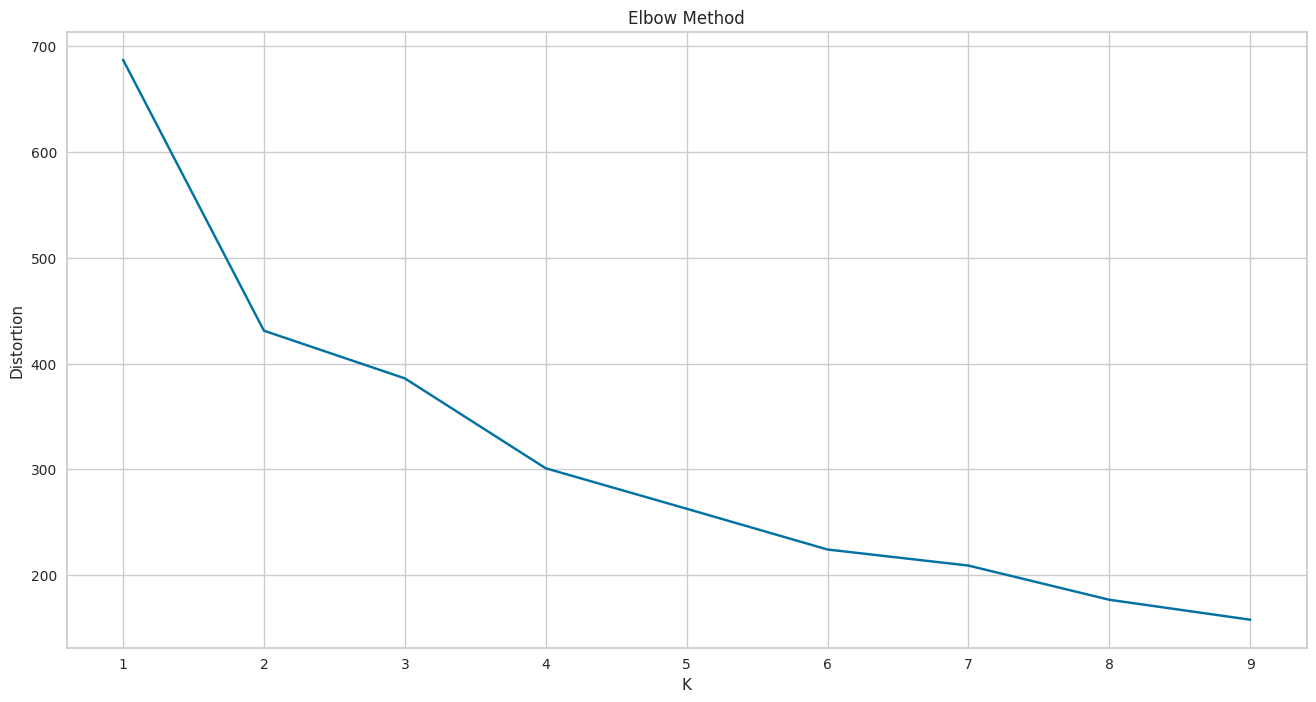

In [233]:
plot_kmeans_elbow(data_clust)

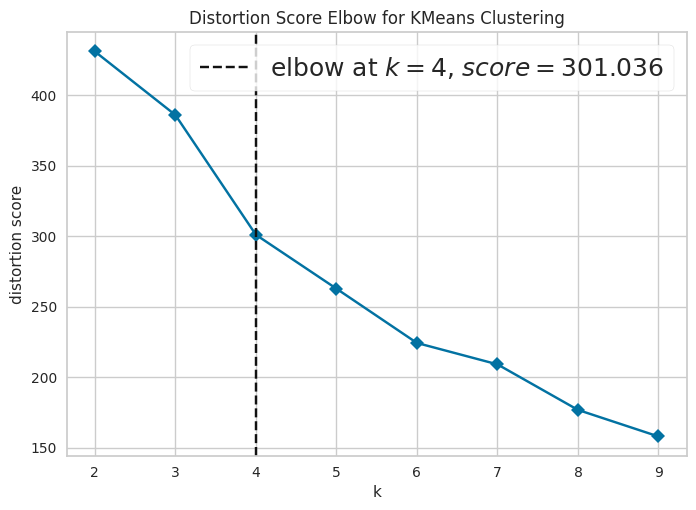

In [234]:
plot_yellowbrick_elbow(data_clust)

For n_clusters = 2, The average silhouette_score is : 0.3082180605018191
For n_clusters = 3, The average silhouette_score is : 0.2787299430101312
For n_clusters = 4, The average silhouette_score is : 0.23561769903346053
For n_clusters = 5, The average silhouette_score is : 0.1423989455465231


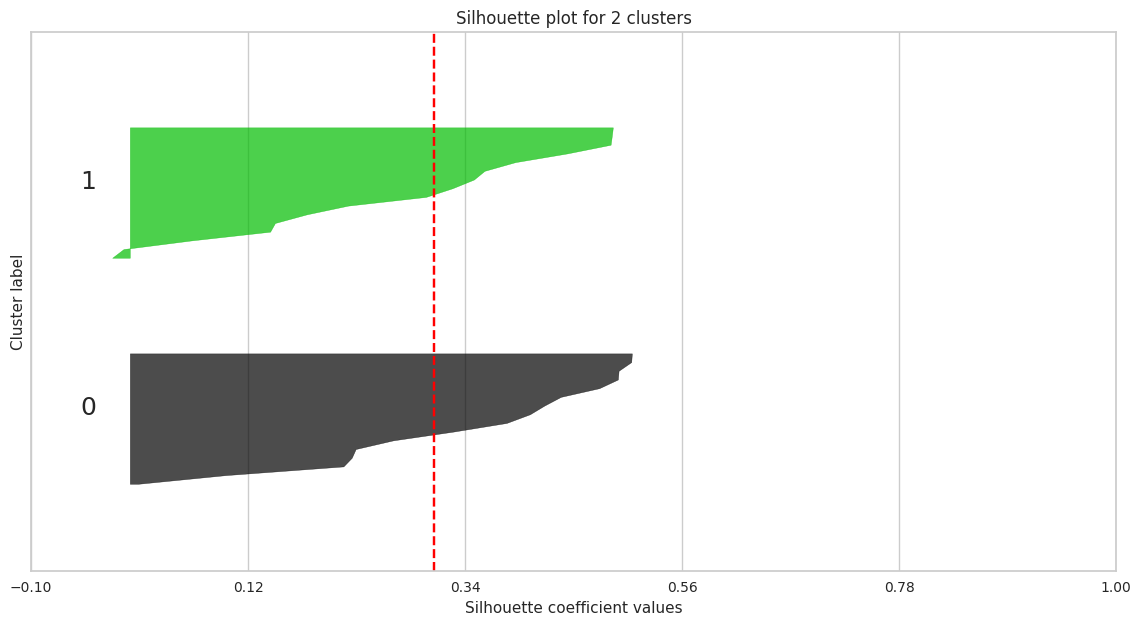

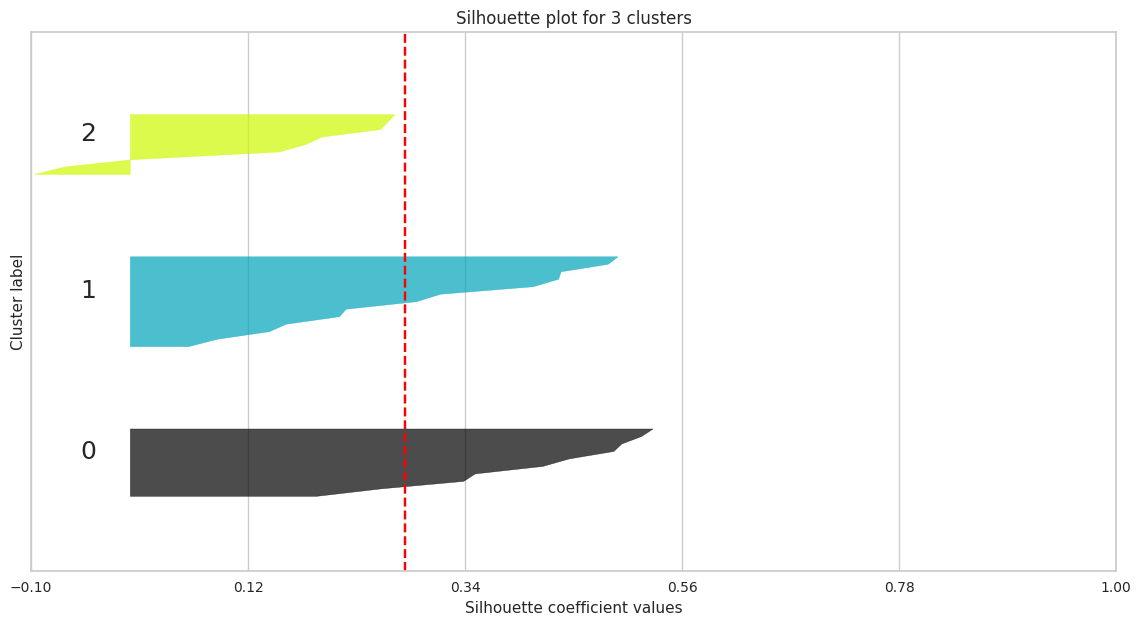

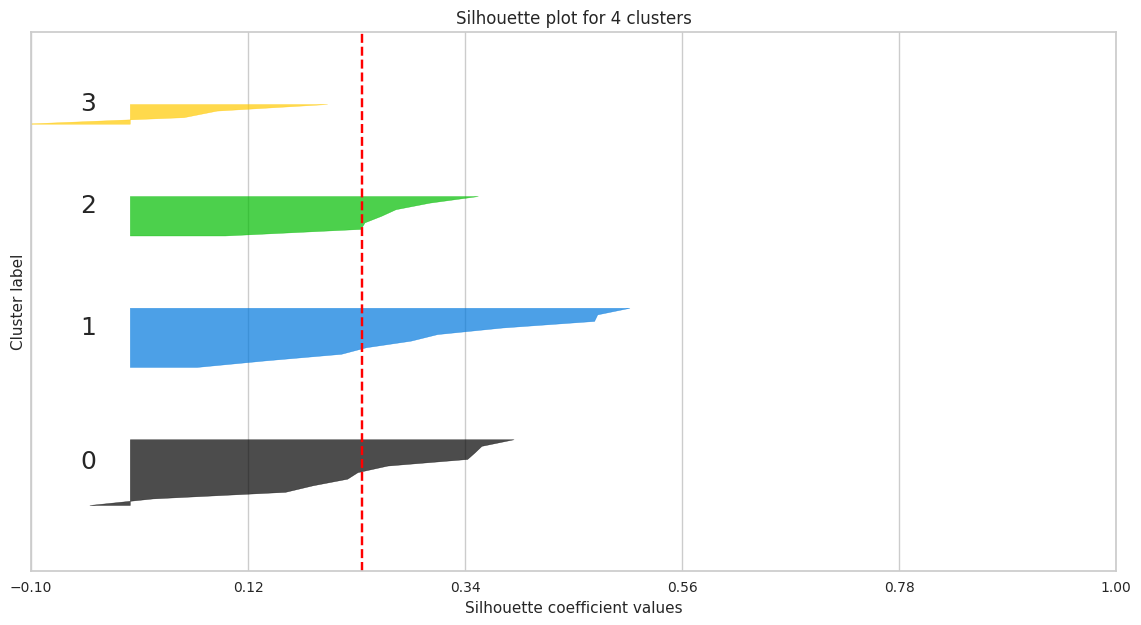

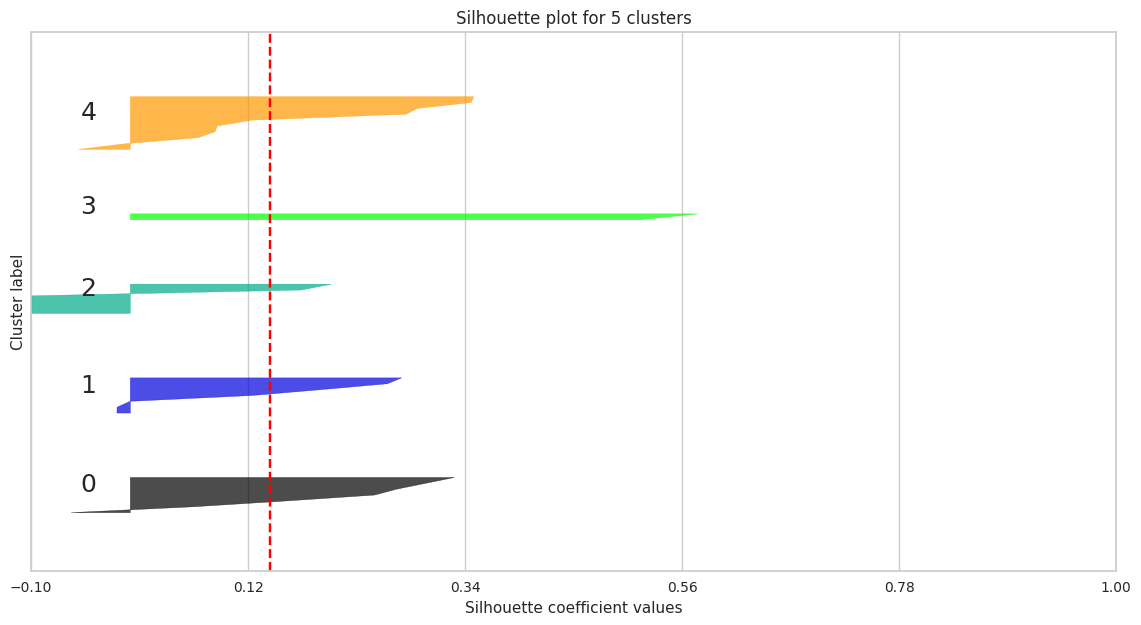

In [235]:
plot_silhouette(data_clust, range_n_clusters=[2, 3, 4, 5])

## KMeans Clustering 

The distortion score was twice as low after implementing the changes, indicating a better fit for the data. While the elbow graph still does not show a clearly defined elbow, the new results suggest the adjustments helped reduce the noise in the clustering process. 

Moving forward, we will proceed with both **K-Means** (k=4) and **Hierarchical Clustering** (k=3) on this refined dataset. 

In [236]:
data_clust["SegmentKM"] = KMeans(n_clusters=4,random_state=42).fit(data_clust).labels_
data_clust["SegmentKM"] = data_clust["SegmentKM"] + 1
data_clust.head(8)

,Reputation,Customer Service,Bill Readability,Flexible Pricing Option,Availability of Renewable Energy,Accessibility of Online Tools,SegmentKM
0,1,5,3,4,6,2,3
1,2,5,4,1,7,6,3
3,7,5,3,2,6,4,1
4,2,7,5,1,3,4,2
6,7,6,5,4,1,2,1
7,1,2,3,4,5,6,4
8,7,4,5,3,1,6,1
9,1,2,3,4,5,7,4


In [237]:
data["SegmentKM"] = data_clust["SegmentKM"]

In [238]:
data.head()

,What is your age?,What is your current living situation?,What type of residence do you live in?,Do you manage the electricity in your household?,How many people live in your household?,How would you describe your household's energy consumption?,How many times have you changed your electricity provider?,How much do you pay for the electricity monthly?,Reputation,Customer Service,Bill Readability,Flexible Pricing Option,Availability of Renewable Energy,Accessibility of Online Tools,Bundles (electricity+gas),SegmentKM
0,18-25,Affitto,Appartamento,Si,2,Basso (es. uso minimo di riscaldamento/aria co...,Mai,40-60€,1,5,3,4,6,2,7,3
1,51+,Proprietà,Casa,Si,4,Alto (es. uso frequente di riscaldamento/aria ...,Due o più volte,100-120€,2,5,4,1,7,6,3,3
3,26-35,Proprietà,Appartamento,Si,2,Basso (es. uso minimo di riscaldamento/aria co...,Mai,Meno di 40€,7,5,3,2,6,4,1,1
4,36-50,Affitto,Appartamento,Si,2,Moderato (es. uso occasionale del riscaldament...,Mai,Meno di 40€,2,7,5,1,3,4,6,2
6,18-25,Proprietà,Casa,Si,3,Moderato (es. uso occasionale del riscaldament...,Mai,80-100€,7,6,5,4,1,2,3,1


In [239]:
data_clust_size = pd.DataFrame(data_clust.groupby("SegmentKM").size(),columns=["Size"]).T
data_clust_size.insert(0,"Population",len(data_clust))
data_clust_size.loc["%"] = data_clust_size.iloc[0].div(data_clust_size.iloc[0,0]).mul(100).astype(int)
data_clust_size

SegmentKM,Population,1,2,3,4
Size,32,14,6,4,8
%,100,43,18,12,25


   We calculated the size of each cluster by grouping the data by the **SegmentKM** column and counting the number of entries in each cluster. This was presented in both absolute and percentage terms relative to the total population.

In [240]:
data_clust_means = data_clust.groupby("SegmentKM").mean().T
data_clust_means.insert(0,"Population",data_clust.drop(columns="SegmentKM").mean())
data_clust_means.round(2)

SegmentKM,Population,1,2,3,4
Reputation,4.12,6.43,2.83,2.00,2.12
Customer Service,4.44,5.64,4.83,4.75,1.88
Bill Readability,4.00,4.07,5.83,3.50,2.75
Flexible Pricing Option,3.38,3.57,2.00,4.00,3.75
Availability of Renewable Energy,3.78,3.07,2.50,6.00,4.88
Accessibility of Online Tools,3.97,2.29,5.00,4.00,6.12


For each cluster, we calculated the mean values of the attributes, and added the overall population mean for comparison. The results were rounded to two decimal places.

In [241]:
X = data_clust.copy()

def style_columns(df, segment_col):
    """ Returns a styling function for use with DataFrame.style.apply """
    def style_func(col):
        if col.name == "Population": 
            return ["background-color: white"] * len(col)
        
        segment_data = df[df[segment_col] == col.name]
        rest_pop_data = df[df[segment_col] != col.name]
       
        colors = []
        for var, var_segment_mean in col.items():
            _, p_value = stats.ttest_ind(segment_data[var], rest_pop_data[var], equal_var=False)
            if p_value < 0.05:
                color = "background-color: green" if var_segment_mean > rest_pop_data[var].mean() else "background-color: red"
            elif p_value < 0.1:
                color = "background-color: #90ee90" if var_segment_mean > rest_pop_data[var].mean() else "background-color: #f1807e"
            else: 
                color = "background-color: white"
            colors.append(color)
        return colors
    return style_func

# Apply to data_clust
data_clust_means = data_clust.groupby("SegmentKM").mean().T
data_clust_means.insert(0, "Population", data_clust.drop(columns="SegmentKM").mean())
data_clust_means.style.apply(style_columns(data_clust, "SegmentKM")).format("{:.2f}")

SegmentKM,Population,1,2,3,4
Reputation,4.12,6.43,2.83,2.00,2.12
Customer Service,4.44,5.64,4.83,4.75,1.88
Bill Readability,4.00,4.07,5.83,3.50,2.75
Flexible Pricing Option,3.38,3.57,2.00,4.00,3.75
Availability of Renewable Energy,3.78,3.07,2.50,6.00,4.88
Accessibility of Online Tools,3.97,2.29,5.00,4.00,6.12


We applied a statistical test (t-test) to compare the mean values of each attribute between a specific cluster and the rest of the population. The styling function applied color coding to highlight significant differences:

Green/red for attributes where the cluster mean is significantly higher/lower than the overall population.

- Segment 1: Prioritizes reputation and customer service. They may be more loyal and value traditional service aspects.
- Segment 2: Values bill readability and accessibility of online tools. They likely prefer clear communication and digital convenience.
- Segment 3: Focuses on flexible pricing options and renewable energy. They may be cost-conscious and environmentally aware.
- Segment 4: Highly values the accessibility of online tools and renewable energy. They are likely tech-savvy and environmentally conscious.

## Segmentation space using PCA

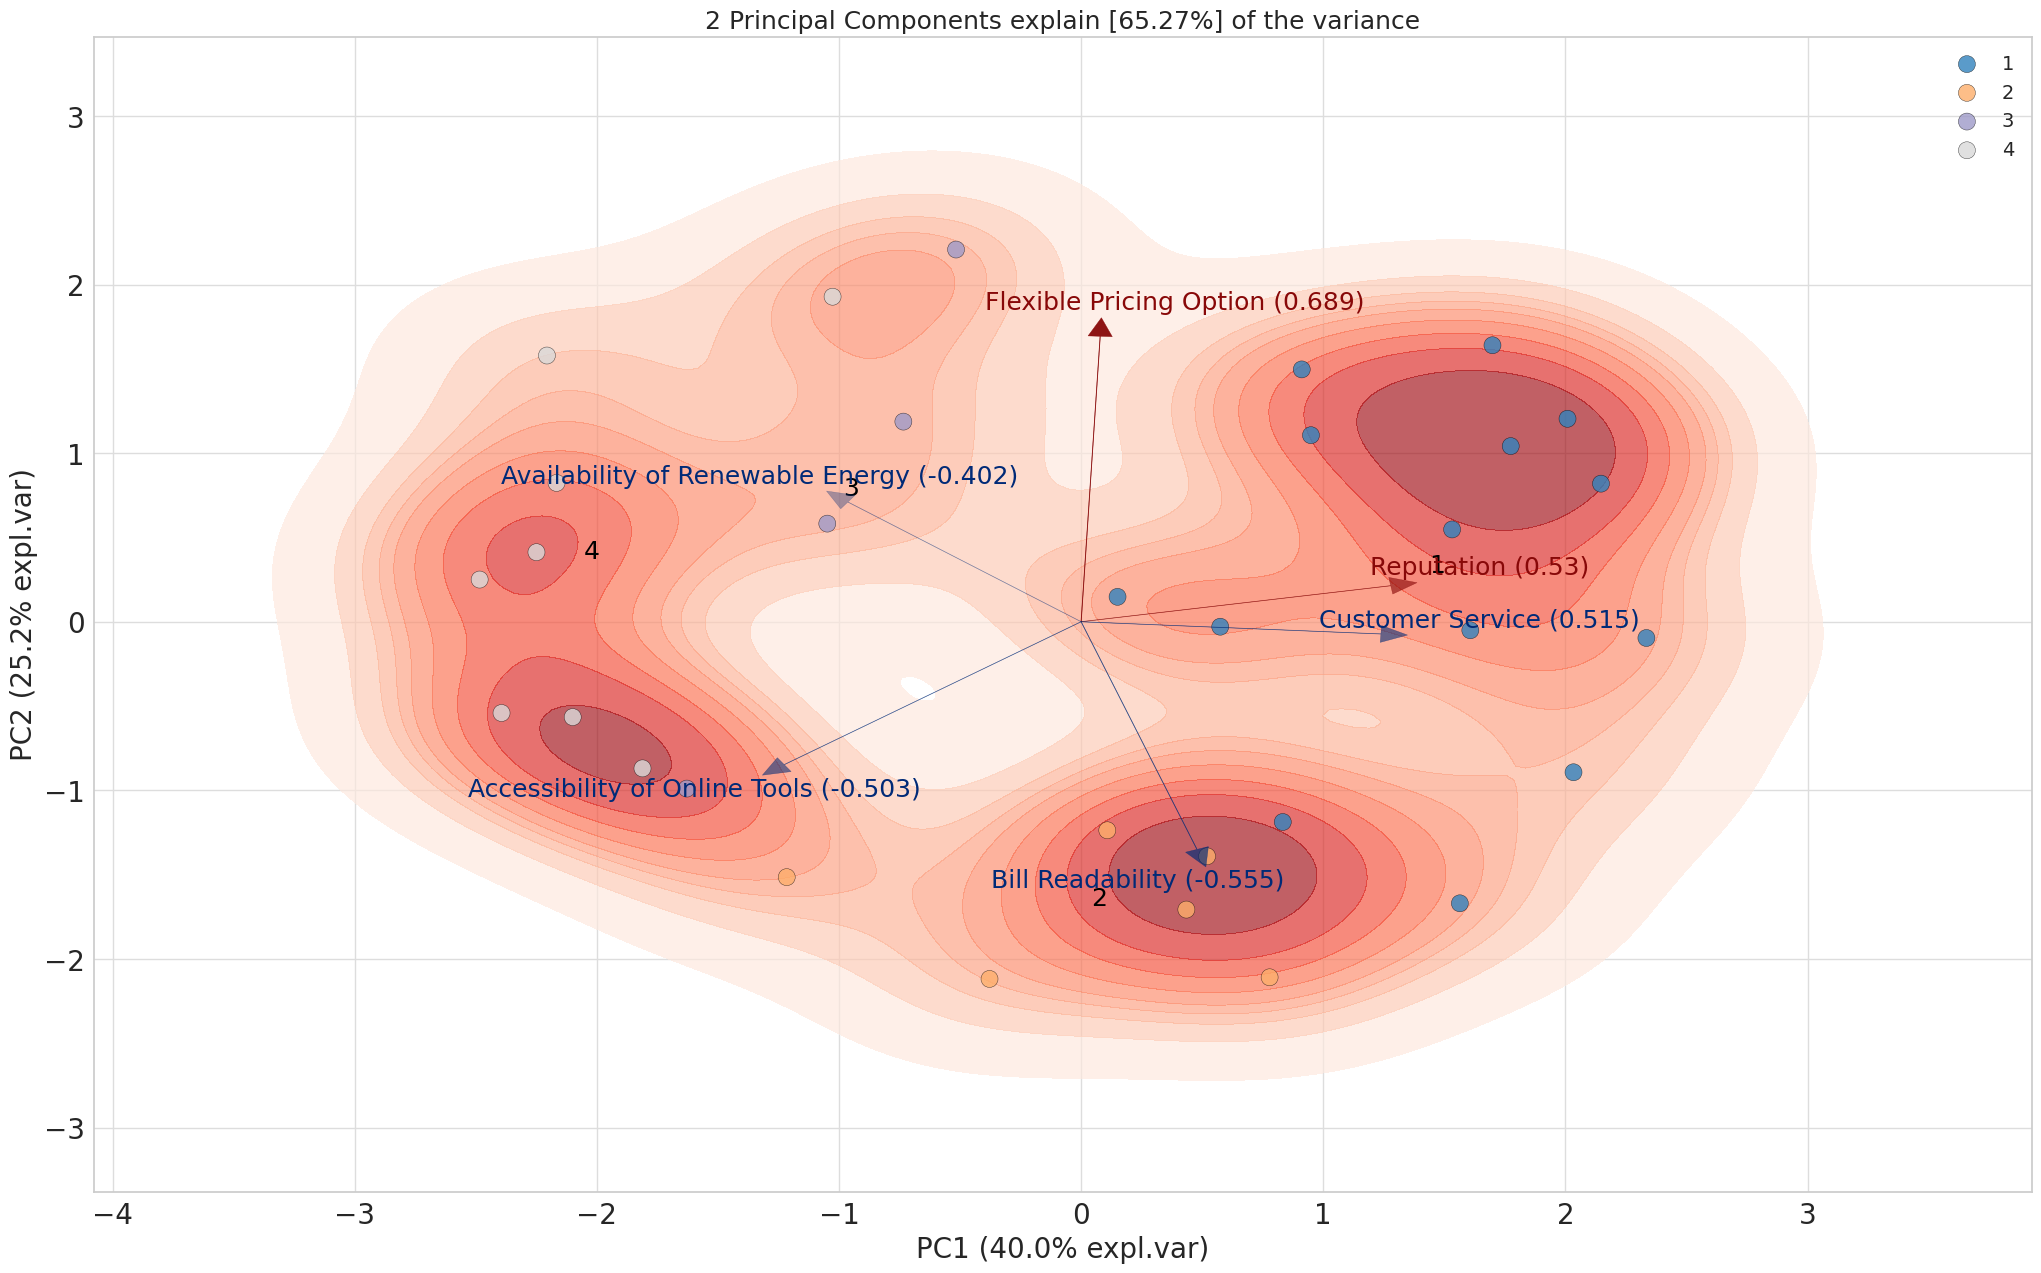

In [242]:
logging.disable(sys.maxsize)

model = pca(n_components=2,normalize=True, random_state=42)

features = data_clust.drop(columns="SegmentKM")
segments = data_clust.SegmentKM

# Fit transform
results = model.fit_transform(features,verbose=False)
# Make biplot with the number of features
# Strenght of the loadings are shown in two colors (red=strong, blue=weak)
fig, ax = model.biplot(labels=segments,verbose=0,density=True)

This PCA plot visualizes the contribution of different variables to the first two principal components, which together explain **65.27%** of the variance in the dataset. 

## Hierarchical Clustering

In [243]:
data_clust.head()   

,Reputation,Customer Service,Bill Readability,Flexible Pricing Option,Availability of Renewable Energy,Accessibility of Online Tools,SegmentKM
0,1,5,3,4,6,2,3
1,2,5,4,1,7,6,3
3,7,5,3,2,6,4,1
4,2,7,5,1,3,4,2
6,7,6,5,4,1,2,1


In [244]:
# Perform Agglomerative Clustering on data_clust without the last column
hc = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="ward")
hc.fit(data_clust.iloc[:,:-1])

# Add the cluster labels to the DataFrame
data_clust["SegmentHC"] = hc.labels_ + 1
data_clust.head(8)

,Reputation,Customer Service,Bill Readability,Flexible Pricing Option,Availability of Renewable Energy,Accessibility of Online Tools,SegmentKM,SegmentHC
0,1,5,3,4,6,2,3,2
1,2,5,4,1,7,6,3,2
3,7,5,3,2,6,4,1,1
4,2,7,5,1,3,4,2,3
6,7,6,5,4,1,2,1,1
7,1,2,3,4,5,6,4,2
8,7,4,5,3,1,6,1,3
9,1,2,3,4,5,7,4,2


In [245]:
# Create a DataFrame with the sizes of each segment
data_clust_sizes_hc = pd.DataFrame(data_clust.groupby("SegmentHC").size(), columns=["Size"]).T
data_clust_sizes_hc.insert(0, "Population", len(data_clust))
data_clust_sizes_hc.loc["%"] = data_clust_sizes_hc.iloc[0].div(data_clust_sizes_hc.iloc[0, 0]).mul(100).astype(int)
data_clust_sizes_hc

SegmentHC,Population,1,2,3
Size,32,14,12,6
%,100,43,37,18


### Dendrogram Visualization
To better understand the hierarchical clustering structure, we created a dendrogram using Ward's linkage method. The dendrogram provides insight into how clusters merge at different levels.

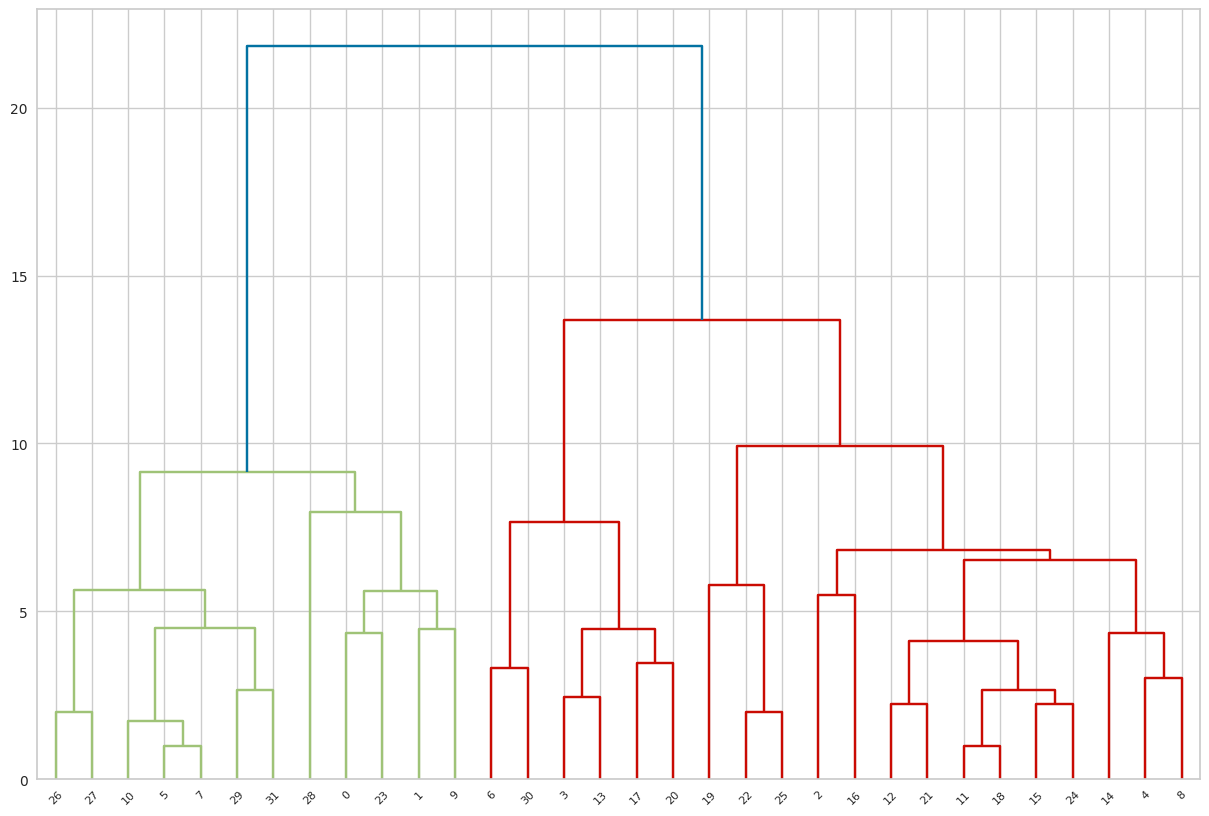

In [246]:
# Drop the SegmentKM and SegmentHC columns
X = data_clust.drop(columns=["SegmentKM", "SegmentHC"])

# Plot the hierarchical clustering as a dendrogram
tree = hierarchy.linkage(X, 'ward')
plt.figure(figsize=(15, 10))
dn = hierarchy.dendrogram(tree)
plt.show()

# Descriptor Analysis

First, we prepared and transformed categorical survey responses into numerical values to facilitate the analysis. To focus on key demographic and behavioral attributes, we extracted the first seven columns into a new DataFrame called data_descriptor. 

We included the SegmentKM column to allow further analysis of how different clusters compare in terms of their descriptive attributes.

In [247]:
# Descriptor Analysis

# Mapping dictionary for columns
mappings = {
    'What type of residence do you live in?': {'Appartamento': 0, 'Casa': 1},
    'What is your current living situation?': {'Affitto': 0, 'Proprietà': 1},
    'What is your age?': {'18-25': 0, '26-35': 1, '36-50': 2, '51+': 3},
    'How many times have you changed your electricity provider?': {'Mai': 0, 'Una volta': 1, 'Due o più volte': 2},
    'How would you describe your household\'s energy consumption?': {
        'Basso (es. uso minimo di riscaldamento/aria condizionata)': 0,
        'Moderato (es. uso occasionale del riscaldamento/aria condizionata)': 1,
        'Alto (es. uso frequente di riscaldamento/aria condizionata, più dispositivi in funzione)': 2
    },
    'How much do you pay for the electricity monthly?': {
        'Meno di 40€': 0, '40-60€': 1, '60-80€': 2, '80-100€': 3,
        '100-120€': 4, 'Più di 120€': 5
    }
}

# Apply mappings and handle NaN for electricity provider changes
for column, mapping in mappings.items():
    data[column] = data[column].replace(mapping).fillna(0)

# Drop the unnecessary column
data.drop(columns=['Do you manage the electricity in your household?'], inplace=True)

# Create a new DataFrame for descriptor analysis and directly select columns
data_descriptor = data.iloc[:, :7].copy()

# Add the 'SegmentKM' column to the descriptor DataFrame
data_descriptor["SegmentKM"] = data["SegmentKM"]

# Handle non-numeric or missing values for specific columns
for col in ['How many people live in your household?', 'How many times have you changed your electricity provider?']:
    data_descriptor[col] = pd.to_numeric(data_descriptor[col], errors='coerce').fillna(0).astype(int)

# Rename columns for clarity
data_descriptor.columns = [
    "Age", "Renter/Owner", "Residence Type", "Number of Residents",
    "Energy Consumption", "Electricity Provider Changes", "Electricity Payment", "SegmentKM"
]

In [248]:
data_descriptor.head()

,Age,Renter/Owner,Residence Type,Number of Residents,Energy Consumption,Electricity Provider Changes,Electricity Payment,SegmentKM
0,0,0,0,2,0,0,1,3
1,3,1,1,4,2,2,4,3
3,1,1,0,2,0,0,0,1
4,2,0,0,2,1,0,0,2
6,0,1,1,3,1,0,3,1


In [249]:
# Calculate the means for each segment
data_descriptor_means = data_descriptor.groupby("SegmentKM").mean().T
data_descriptor_means.insert(0, "Population", data_descriptor.drop(columns="SegmentKM").mean())
data_descriptor_means.round(2)

SegmentKM,Population,1,2,3,4
Age,2.03,2.14,1.67,2.25,2.00
Renter/Owner,0.59,0.93,0.50,0.25,0.25
Residence Type,0.31,0.50,0.00,0.25,0.25
Number of Residents,2.75,3.43,2.00,2.50,2.25
Energy Consumption,1.22,1.43,1.17,1.00,1.00
Electricity Provider Changes,0.84,0.86,0.67,1.00,0.88
Electricity Payment,2.62,3.21,1.67,2.25,2.50


The Population column shows the average values for each attribute across the entire dataset, while the other columns show the average values for each attribute within each specific cluster.

In [250]:
data_descriptor_means.style.apply(style_columns(data_descriptor, "SegmentKM")).format("{:.2f}")

SegmentKM,Population,1,2,3,4
Age,2.03,2.14,1.67,2.25,2.00
Renter/Owner,0.59,0.93,0.50,0.25,0.25
Residence Type,0.31,0.50,0.00,0.25,0.25
Number of Residents,2.75,3.43,2.00,2.50,2.25
Energy Consumption,1.22,1.43,1.17,1.00,1.00
Electricity Provider Changes,0.84,0.86,0.67,1.00,0.88
Electricity Payment,2.62,3.21,1.67,2.25,2.50


Segment 1: This segment tends to have more homeowners with higher energy consumption and electricity payment. Moreover, they have a higher number of people living with them as well as the highest proportion of the house/apartment ratio. They may be more established and have higher energy needs.

Segment 2: This segment has younger customers who live in apartments, with the lowest number of residents and electricity payment. They also rarely change their electricity providers. 

Segments 3 and 4: These segments fall somewhere in between, with moderate values across most attributes.

## Descriptor Space using PCA

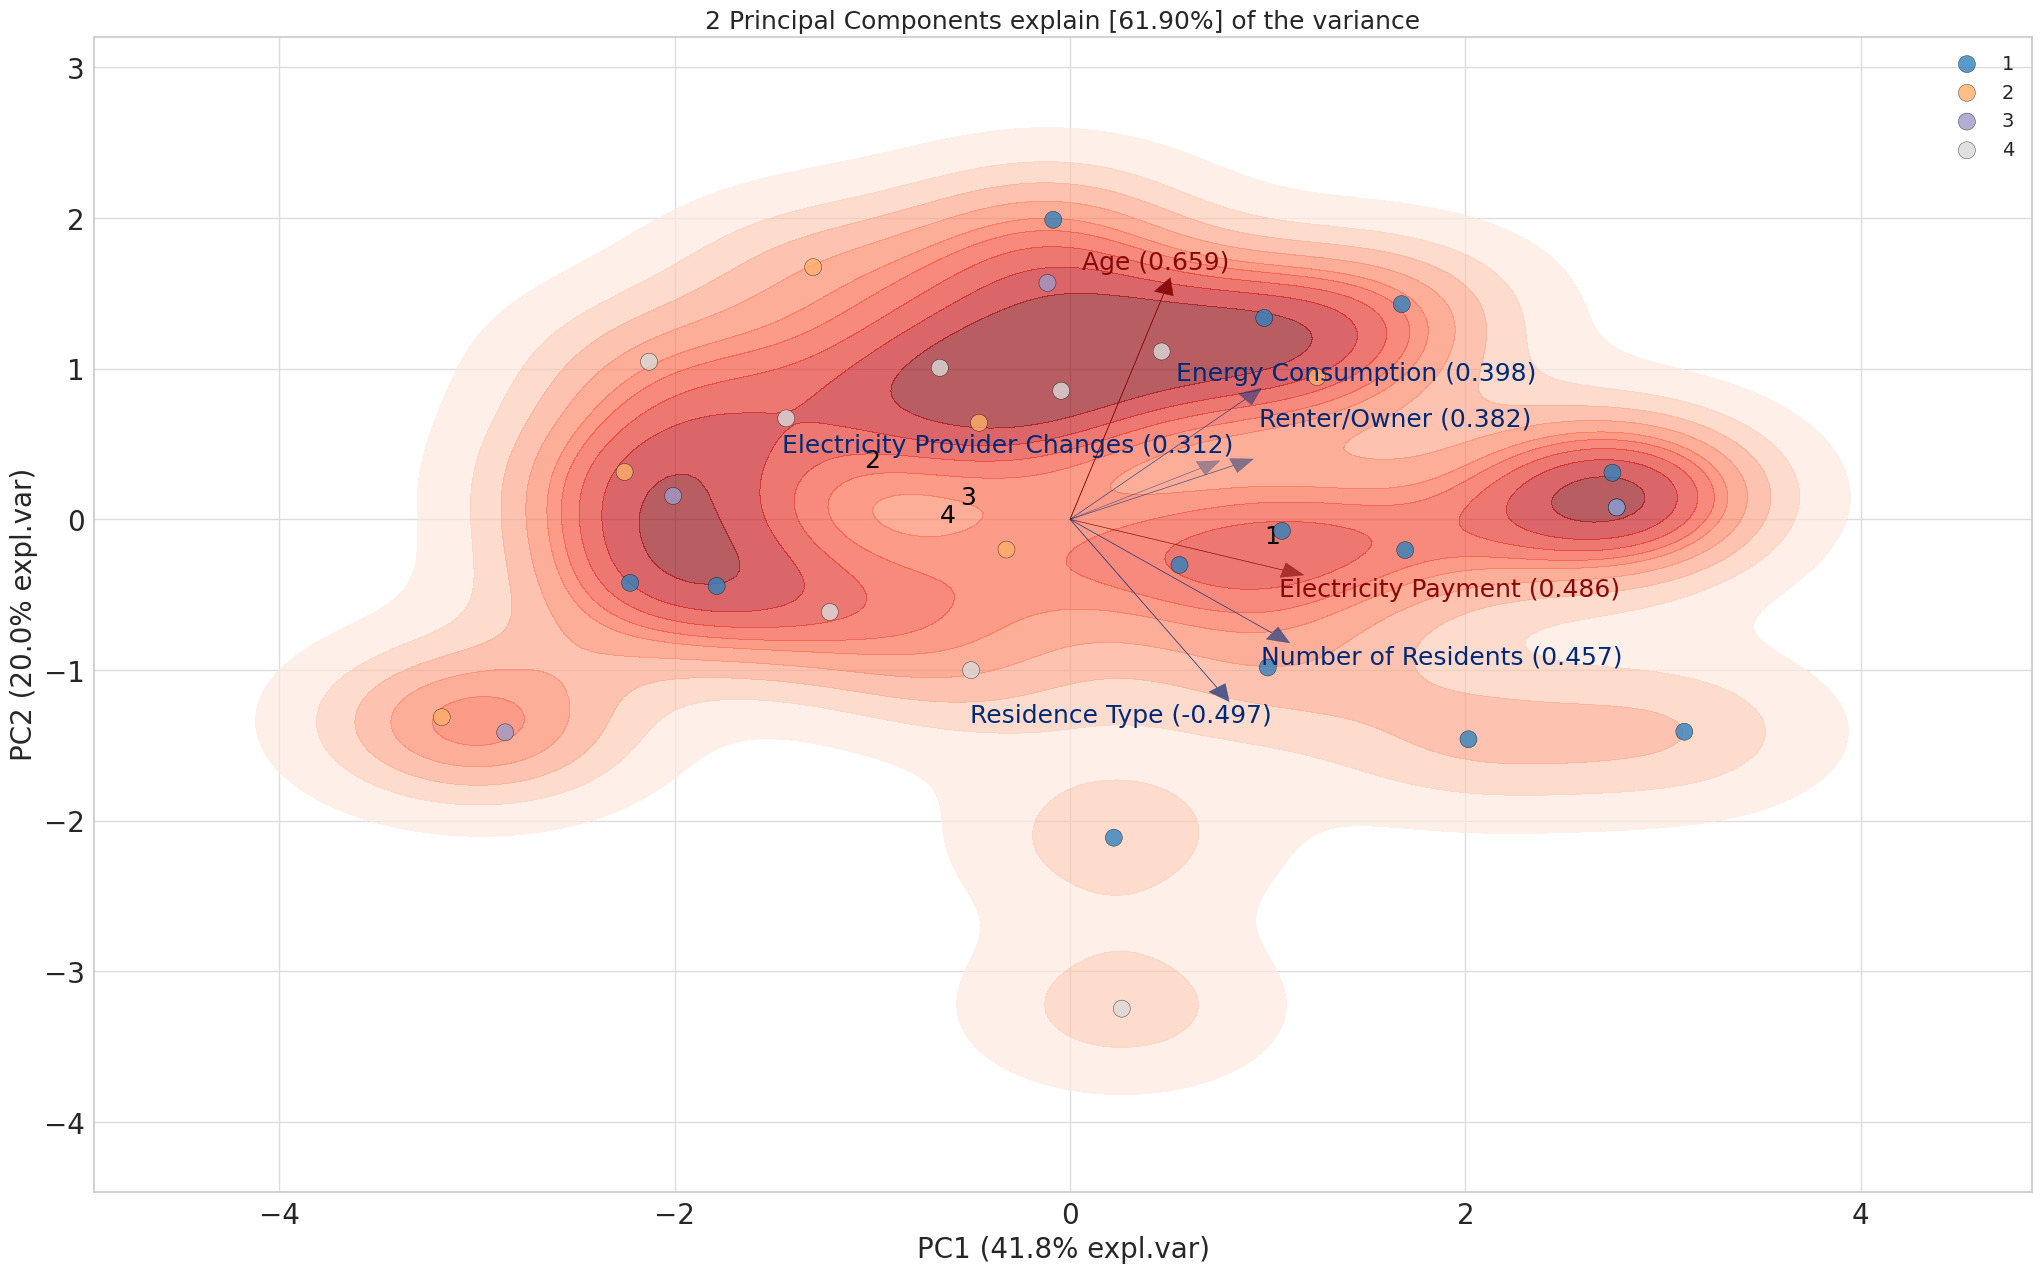

In [251]:
# Perform PCA for visualization
logging.disable(sys.maxsize)

model = pca(n_components=2, normalize=True, random_state=42)

features = data_descriptor.drop(columns="SegmentKM")
segments = data_descriptor.SegmentKM

# Fit transform
results = model.fit_transform(features, verbose=False)
# Make biplot with the number of features
# Strength of the loadings are shown in two colors (red=strong, blue=weak)
fig, ax = model.biplot(labels=segments, verbose=0, density=True)


This PCA visualization represents two principal components (PC1 & PC2), explaining **61.90%** of the variance.

- Age is a dominant factor in PC1.
- Residence Type influences PC1 in the opposite direction.
- Electricity behaviors (Payment & Provider Changes) contribute to segmentation.
- Larger households cluster in a specific direction.


## Feature Importance Analysis

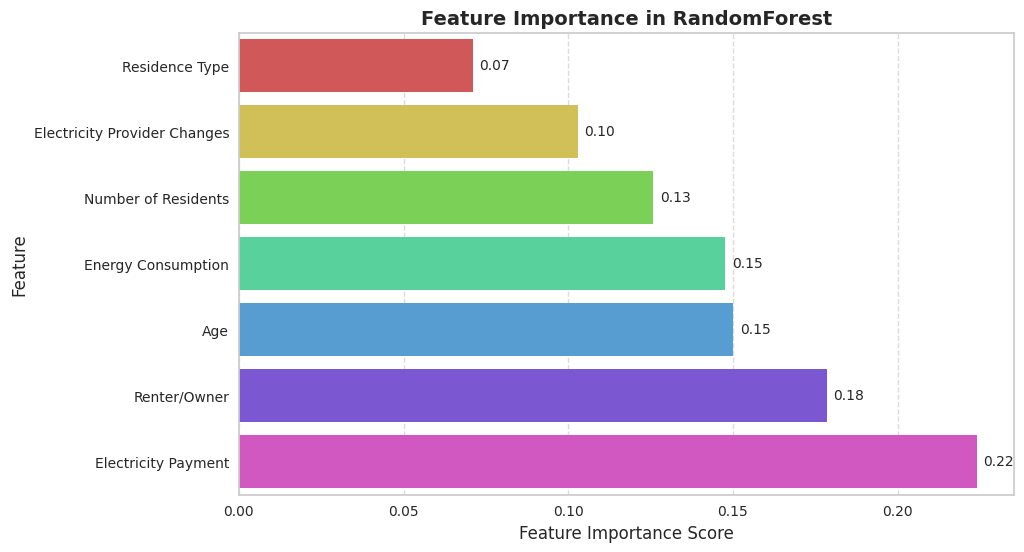

In [252]:
# Train RandomForest
X = data_descriptor.drop(columns="SegmentKM")
y = data_descriptor["SegmentKM"]

rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(X, y)

# Extract Feature Importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)  # Sort for better visualization

# Generate Custom Colors Matching the Sankey Diagram
def generate_colors(n):
    colors = []
    for i in range(n):
        hue = i / n  # Distribute colors evenly across the HSV spectrum
        rgb = colorsys.hsv_to_rgb(hue, 0.7, 0.9)  # Convert to RGB
        hex_color = f'#{int(rgb[0]*255):02x}{int(rgb[1]*255):02x}{int(rgb[2]*255):02x}'  # Convert to hex
        colors.append(hex_color)
    return colors

feature_colors = generate_colors(len(importances))  # Generate a unique color per feature

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette=feature_colors)  # Use custom colors

# Style Adjustments
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Importance in RandomForest", fontsize=14, fontweight="bold")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show values on bars
for index, value in enumerate(importances.values):
    plt.text(value + 0.002, index, f"{value:.2f}", va="center", fontsize=10)

plt.show()

This code trains a **RandomForestClassifier** on the classification of `SegmentKM` to analyze feature importance and visualize the results. The analysis shows that Electricity Payment and homeownership status are the most influential factors in segment classification, whereas Residence Type has the least impact.